<a href="https://colab.research.google.com/github/lucaCosca/JetNet_ML-Final-Project/blob/main/Jet_Tagging_data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

class DataVisualization:
  def __init__(self, X_train_set, Y_train_set, X_valid_set=None, Y_valid_set=None, classifier=None, classifier_str="model", cmap='magma'):
    self.X_train = X_train_set
    self.Y_train = Y_train_set
    self.X_valid = X_valid_set
    self.Y_valid = Y_valid_set
    self.cmap = cmap
    self.classifier_str = classifier_str
    self.classifier = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=10)
    if classifier is not None:
      self.classifier = classifier

    print("X_train shape: ", self.X_train.shape)
    print("Y_train shape: ", self.Y_train.shape)
    if self.X_valid is not None:
      print("X_valid shape: ", self.X_valid.shape)
      print("Y_valid shape: ", self.Y_valid.shape)

  def view_one_image(self, n=None):
    if n == None:
      n = np.random.randint(0, self.X_train.shape[0])
    plt.imshow(self.X_train[n], cmap='gray', vmin=0, vmax=1)

  def feauture_importance(self):
    self.classifier.fit(self.X_train.reshape(self.X_train.shape[0], -1), self.Y_train)
    feat_imp = self.classifier.feature_importances_.reshape(100,100)
    print("max(a) = ", np.max(feat_imp))
    print("min(a) = ", np.min(feat_imp))
    # Adjust figure size as needed
    plt.figure(figsize=(8, 4))
    # Main image plot
    plt.subplot(1, 2, 1)
    plt.imshow(feat_imp, cmap='magma')  # Use magma colormap
    plt.colorbar(label='Feature Importance')  # Add a colorbar with label
    plt.title('Feature Importance')
    # Logarithmic image plot
    plt.subplot(1, 2, 2)
    plt.imshow(np.log(feat_imp), cmap='magma') # Use magma colormap
    plt.colorbar(label='log(Feature Importance)') # Add a colorbar with label
    plt.title('Logarithmic Feature Importance')
    #end
    plt.tight_layout()  # Adjust subplot parameters for a tight layout
    plt.show()

  def confusion_matrix_Kfolds(self, number_of_kfolds=3, ONEHOTENCODED=False):
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import confusion_matrix

    if ONEHOTENCODED:
      Y = np.argmax(self.Y_train.reshape(self.X_train.shape[0], -1), axis=1)
    else:
      Y = self.Y_train.reshape(self.X_train.shape[0], -1)

    Y_train_pred = cross_val_predict(self.classifier, self.X_train.reshape(self.X_train.shape[0], -1), Y, cv=number_of_kfolds)
    conf_m = confusion_matrix(Y, Y_train_pred)
    print("Confusion matrix of " + self.classifier_str + " over 3 K-Folds")
    print(conf_m)
    plt.matshow(conf_m, cmap=plt.cm.gray)
    plt.title("Confusion matrix of " + self.classifier_str + " over 3 K-Folds")
    plt.xticks(range(5), ["gluon", "quark", "W boson", "Z boson", "top quark"])
    plt.yticks(range(5), ["gluon", "quark", "W boson", "Z boson", "top quark"])

  def format_class(self, jetclass):
    if jetclass[0] == 1:
      return "gluon"
    elif jetclass[1] == 1:
      return "quark"
    elif jetclass[2] == 1:
      return "W boson"
    elif jetclass[3] == 1:
      return "Z boson"
    elif jetclass[4] == 1:
      return "top quark"

  def view_multiple_images(self, number_of_images=8):
    #questa cella plotta 8 diverse immagini scelte randomicamente con le relative classi,
    #ad ogni run della cella cambiano le immagini plottate
    plt.subplots(2,4, figsize=(16,8))
    for i in range(number_of_images):
      plt.subplot(2,4,i+1)
      n = np.random.randint(0, self.X_train.shape[0])
      plt.imshow(self.X_train[n], cmap='gray', vmin=0, vmax=1)
      plt.title(self.format_class(self.Y_train[n]))
    plt.show()

  def plot_precision_vs_recall(self, model_str, precisions, recalls, average_precision, SHOW = True):
    for i in range(precisions.shape[0]):
      plt.plot(recalls[i], precisions[i], label='Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Model: " + model_str)
    plt.savefig("plots/" + model_str + "_precision_vs_recall.png")
    if SHOW:
      plt.show()

  def PR_study_multiclass(self, cv=3, method="predict_proba"):
    from sklearn.multiclass import OneVsRestClassifier
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import average_precision_score, precision_recall_curve
    """
    Performs Precision-Recall analysis for multiclass classification.
    Args:
      x: Input features.
      y: Target labels (multiclass).
      model: The classifier model.
      model_str: Model name for plotting.
      cv: Number of cross-validation folds.
    """
    # Binarize the labels for OvA
    classes = np.unique(self.Y_train)
    y_bin = label_binarize(self.Y_train, classes=classes)
    n_classes = y_bin.shape[1]
    # Wrap the model with OneVsRestClassifier for OvA
    classifier_OvA = OneVsRestClassifier(self.classifier)
    y_score = cross_val_predict(classifier_OvA, self.X_train, y_bin, cv=cv, method=method)
    # Precision-Recall analysis for each class
    average_precision = dict()
    for i in range(n_classes):
        precisions, recalls, tresholds = precision_recall_curve(y_bin[:, i], y_score[:, i])
        average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
    # A "micro-average": quantifying score on all classes jointly
    precision_micro, recall_micro, treshold_micro = precision_recall_curve(y_bin.ravel(), y_score.ravel())
    average_precision_micro = average_precision_score(y_bin, y_score, average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision_micro))
    self.plot_precision_vs_recall(self.classifier_str, precisions, recalls, average_precision)
    #for RandomForestClassifier -> method="predict_proba"
    #for Stochastic Gradient Descent -> method="decision_function"


In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")
path = "gdrive/MyDrive/"

Mounted at /content/gdrive


In [ ]:
dataset1 = np.load(path + "Jets/jetImage_7_100p_0_10000.npz")
jetimage1 = dataset1['jetImage']
jetclass1 = dataset1['jetClass']

dataset_test = np.load(path + "Jets/jetImage_7_100p_60000_70000.npz")
jetimage_test = dataset_test['jetImage']
jetclass_test = dataset_test['jetClass']

In [ ]:
data = DataVisualization(jetimage1[:], jetclass1[:], classifier=RandomForestClassifier(n_estimators=2000, n_jobs=-1, max_depth=10), classifier_str="RandomForest")
data.confusion_matrix_Kfolds(ONEHOTENCODED=True)

X_train shape:  (10000, 100, 100)
Y_train shape:  (10000, 5)


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import colormaps

In [ ]:
N=100
X_train = jetimage1[0:N]
Y_train = jetclass1[0:N]
rand_forest = RandomForestClassifier(n_estimators=500, n_jobs=-1, max_depth=10)
rand_forest.fit(X_train.reshape(N, -1), Y_train)

RandomForestClassifier(max_depth=10, n_estimators=500, n_jobs=-1)

In [ ]:
a = rand_forest.feature_importances_.reshape(100,100)
print("max(a) = ", np.max(a))
print("min(a) = ", np.min(a))

max(a) =  0.045369906869250784
min(a) =  0.0


<ipython-input-56-370e5c751526>:11: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(a), cmap='magma') # Use magma colormap


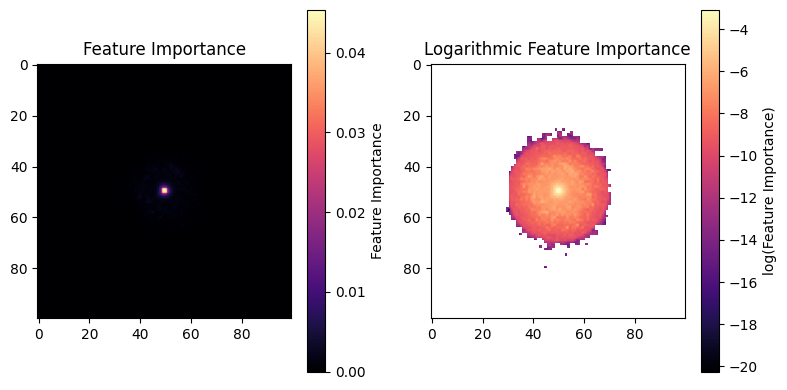

In [ ]:
plt.figure(figsize=(8, 4))  # Adjust figure size as needed

# Main image plot
plt.subplot(1, 2, 1)
plt.imshow(a, cmap='magma')  # Use magma colormap
plt.colorbar(label='Feature Importance')  # Add a colorbar with label
plt.title('Feature Importance')

# Logarithmic image plot
plt.subplot(1, 2, 2)
plt.imshow(np.log(a), cmap='magma') # Use magma colormap
plt.colorbar(label='log(Feature Importance)') # Add a colorbar with label
plt.title('Logarithmic Feature Importance')

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

(10000,)
Confusion matrix of RF over 3 K-Folds
[[1014  448  110   40  435]
 [ 336 1275  164   42  187]
 [ 237  354 1024  311   99]
 [ 194  253  743  541  230]
 [ 119   72  214   99 1459]]


AttributeError: AxesImage.set() got an unexpected keyword argument 'title'

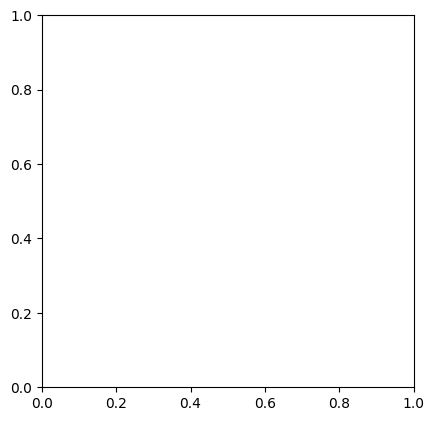

In [ ]:
'''Confusion matrix'''
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

N=10000
X_train = jetimage1[0:N].reshape(N, -1)
Y_train = jetclass1[0:N].reshape(N, -1)
Y = np.argmax(Y_train, axis=1)

rand_f2 = RandomForestClassifier(n_estimators=2000, n_jobs=-1, max_depth=10)
Y_train_pred = cross_val_predict(rand_f2, X_train, Y, cv=3)
print(Y_train_pred.shape)
conf_m = confusion_matrix(Y, Y_train_pred)
print("Confusion matrix of RF over 3 K-Folds")
print(conf_m)
plt.matshow(conf_m, cmap=plt.cm.gray)
plt.title("Confusion matrix of RF over 3 K-Folds")

Text(0.5, 1.0, 'Confusion matrix of RF over 3 K-Folds')

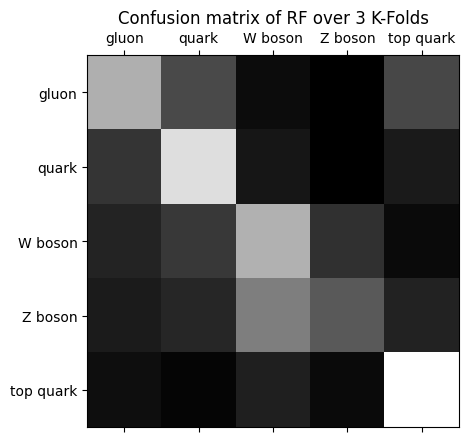

In [ ]:
plt.matshow(conf_m, cmap=plt.cm.gray)
plt.xticks(range(5), ["gluon", "quark", "W boson", "Z boson", "top quark"])
plt.yticks(range(5), ["gluon", "quark", "W boson", "Z boson", "top quark"])
plt.title("Confusion matrix of RF over 3 K-Folds")

In [ ]:
'''Precision and Recall'''
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
def plot_precision_recall_vs_threshold(model_str, precisions, recalls, thresholds, SHOW = True):
	plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
	plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
	plt.legend()
	plt.title("Model: " + model_str)
	plt.savefig("plots/" + model_str + "_precision_recall_vs_treshold.png")
	if SHOW:
		plt.show()
def plot_precision_vs_recall(model_str, precisions, recalls, SHOW = True):
	plt.plot(recalls[:-1], precisions[:-1], "b-", label="Precision")
	plt.xlabel("Recall")
	plt.ylabel("Precision")
	plt.title("Model: " + model_str)
	plt.savefig("plots/" + model_str + "_precision_vs_recall.png")
	if SHOW:
		plt.show()
def PR_study(x, y, model, model_str, cv, method):
	y_scores = cross_val_predict(model, x, y, cv=cv, method=method)
	print(y_scores.shape)
	precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
	plt.figure(figsize=(8, 4))
	plt.subplot(1,2,1)
	plot_precision_recall_vs_threshold(model_str, precisions, recalls, thresholds)
	plt.subplot(1,2,2)
	plot_precision_vs_recall(model_str, precisions, recalls)
#for RandomForestClassifier -> method="predict_proba"
#for Stochastic Gradient Descent -> metho="decision_function"

N=100
X_train = jetimage1[0:N].reshape(N, -1)
Y_train = jetclass1[0:N].reshape(N, -1)
Y = np.argmax(Y_train, axis=1)

rand_f3 = RandomForestClassifier(n_estimators=20, n_jobs=-1, max_depth=10)
PR_study(X_train, Y, rand_f3, "RandomForestClassifier", 3, "predict_proba")

(100, 5)


ValueError: multiclass format is not supported

Average precision score, micro-averaged over all classes: 0.28


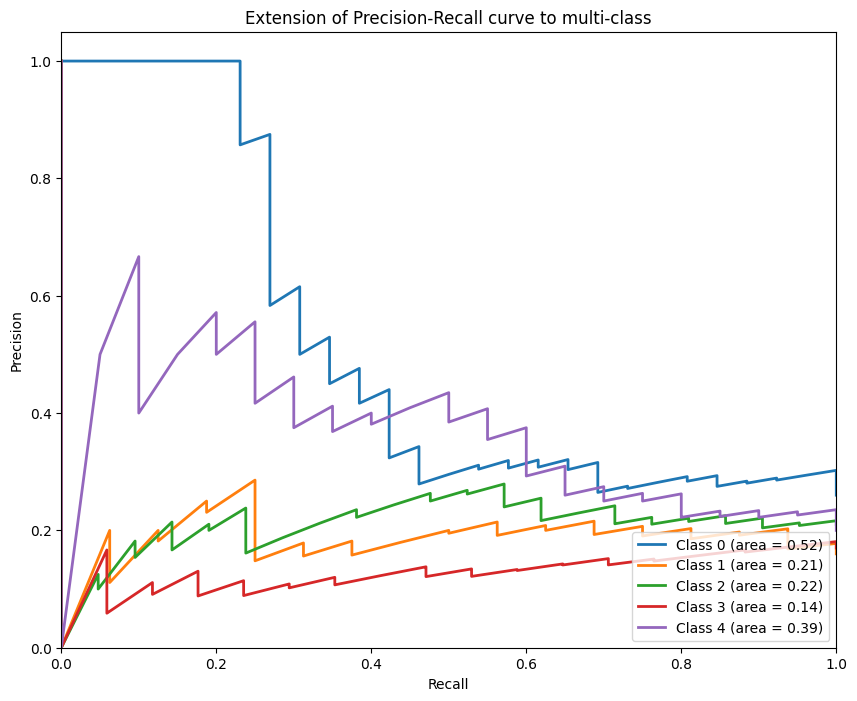

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt

def PR_study(x, y, model, model_str, cv, method):
  """
  Performs Precision-Recall analysis for multiclass classification.
  Args:
    x: Input features.
    y: Target labels (multiclass).
    model: The classifier model.
    model_str: Model name for plotting.
    cv: Number of cross-validation folds.
  """
  # Binarize the labels for OvA
  classes = np.unique(y)
  y_bin = label_binarize(y, classes=classes)
  n_classes = y_bin.shape[1]
  # Wrap the model with OneVsRestClassifier for OvA
  classifier = OneVsRestClassifier(model)
  y_score = cross_val_predict(classifier, x, y_bin, cv=cv, method=method)
  # Precision-Recall analysis for each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  treshold = dict()
  for i in range(n_classes):
      precision[i], recall[i], treshold[i] = precision_recall_curve(y_bin[:, i], y_score[:, i])
      average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(y_bin.ravel(), y_score.ravel())
  average_precision["micro"] = average_precision_score(y_bin, y_score, average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))
  # Plotting for each class
  plt.figure(figsize=(10, 8))  # Adjust figure size if needed
  for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label='Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title("Extension of Precision-Recall curve to multi-class")
  plt.legend(loc="lower right")
  plt.show()

# Example Usage
N = 100
X_train = jetimage1[0:N].reshape(N, -1)
Y_train = jetclass1[0:N].reshape(N, -1)
Y = np.argmax(Y_train, axis=1) # Convert one-hot encoded labels to class indices

rand_f3 = RandomForestClassifier(n_estimators=2000, n_jobs=-1, max_depth=10)
PR_study(X_train, Y, rand_f3, "RandomForestClassifier", 3, "predict_proba")

Average precision score, micro-averaged over all classes: 0.26


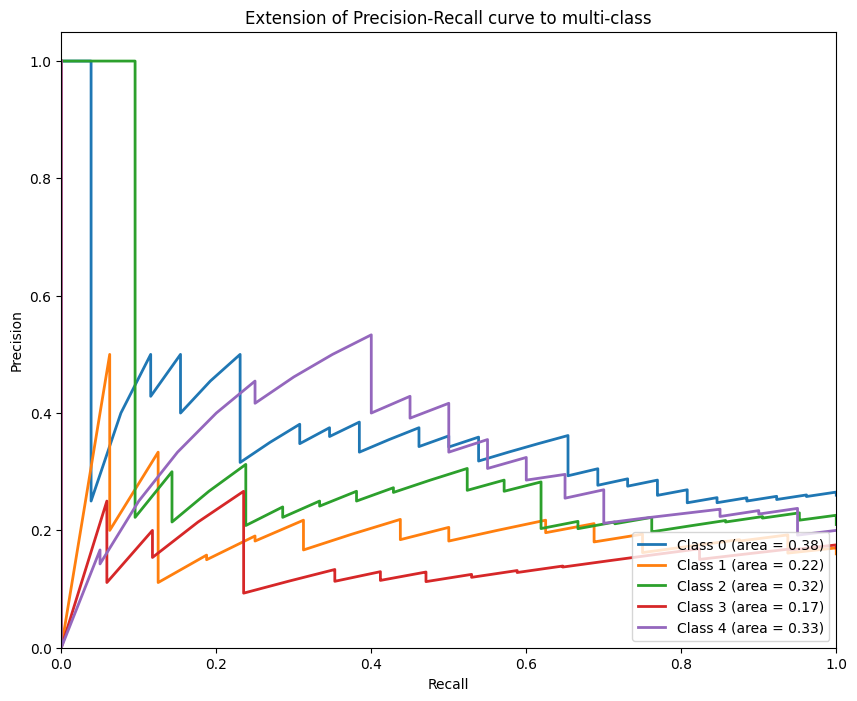

In [ ]:
'''Precision and Recall'''
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
def plot_precision_recall_vs_threshold(model_str, precisions, recalls, thresholds, SHOW = True):
	plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
	plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
	plt.legend()
	plt.title("Model: " + model_str)
	plt.savefig("plots/" + model_str + "_precision_recall_vs_treshold.png")
	if SHOW:
		plt.show()
def plot_precision_vs_recall(model_str, precisions, recalls, average_precision, SHOW = True):
	for i in range(precisions.shape[0]):
		plt.plot(recalls[i], precisions[i], label='Class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
	plt.xlabel("Recall")
	plt.ylabel("Precision")
	plt.title("Model: " + model_str)
	plt.savefig("plots/" + model_str + "_precision_vs_recall.png")
	if SHOW:
		plt.show()
def PR_study_one_class(x, y, model, model_str, cv, method):
	y_scores = cross_val_predict(model, x, y, cv=cv, method=method)
	print(y_scores.shape)
	precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
	plt.figure(figsize=(8, 4))
	plt.subplot(1,2,1)
	plot_precision_recall_vs_threshold(model_str, precisions, recalls, thresholds)
	plt.subplot(1,2,2)
	plot_precision_vs_recall(model_str, precisions, recalls)
def PR_study_multiclass(x, y, model, model_str, cv, method):
  """
  Performs Precision-Recall analysis for multiclass classification.
  Args:
    x: Input features.
    y: Target labels (multiclass).
    model: The classifier model.
    model_str: Model name for plotting.
    cv: Number of cross-validation folds.
  """
  # Binarize the labels for OvA
  classes = np.unique(y)
  y_bin = label_binarize(y, classes=classes)
  n_classes = y_bin.shape[1]
  # Wrap the model with OneVsRestClassifier for OvA
  classifier = OneVsRestClassifier(model)
  y_score = cross_val_predict(classifier, x, y_bin, cv=cv, method=method)
  # Precision-Recall analysis for each class
  average_precision = dict()
  for i in range(n_classes):
      precisions, recalls, tresholds = precision_recall_curve(y_bin[:, i], y_score[:, i])
      average_precision[i] = average_precision_score(y_bin[:, i], y_score[:, i])
  # A "micro-average": quantifying score on all classes jointly
  precision_micro, recall_micro, treshold_micro = precision_recall_curve(y_bin.ravel(), y_score.ravel())
  average_precision_micro = average_precision_score(y_bin, y_score, average="micro")
  print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision_micro))
  plot_precision_vs_recall(model_str, precisions, recalls, average_precision)
#for RandomForestClassifier -> method="predict_proba"
#for Stochastic Gradient Descent -> metho="decision_function"

N=100
X_train = jetimage1[0:N].reshape(N, -1)
Y_train = jetclass1[0:N].reshape(N, -1)
Y = np.argmax(Y_train, axis=1)

rand_f3 = RandomForestClassifier(n_estimators=20, n_jobs=-1, max_depth=10)
PR_study(X_train, Y, rand_f3, "RandomForestClassifier", 3, "predict_proba")

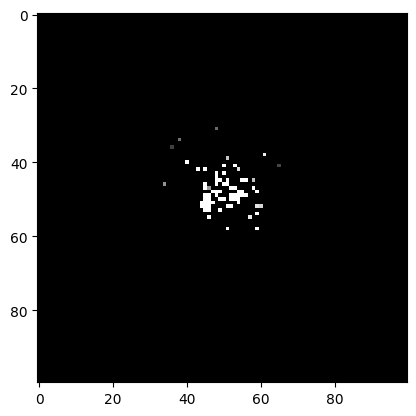

In [ ]:
plt.imshow(jetimage1[0], cmap='gray', vmin=0, vmax=1)
plt.show()

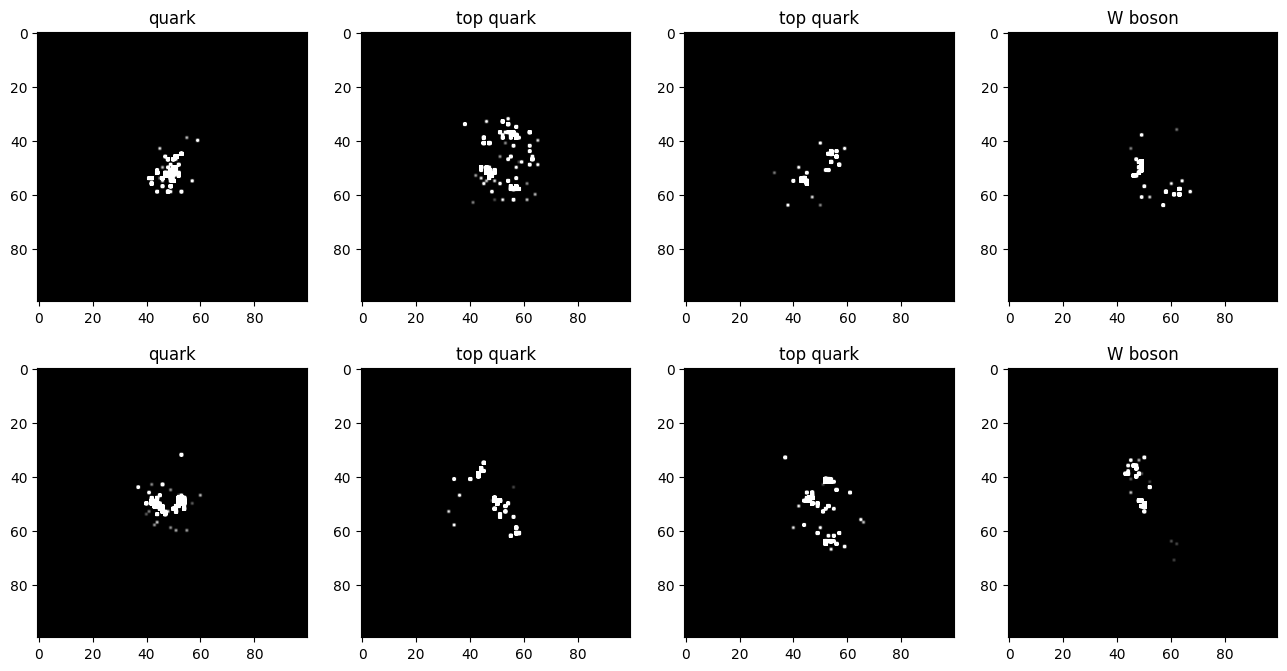

In [ ]:
#questa cella plotta 8 diverse immagini scelte randomicamente con le relative classi,
#ad ogni run della cella cambiano le immagini plottate

a = plt.subplots(2,4, figsize=(16,8))

def format_class(jetclass):
  if jetclass[0] == 1:
    return "gluon"
  elif jetclass[1] == 1:
    return "quark"
  elif jetclass[2] == 1:
    return "W boson"
  elif jetclass[3] == 1:
    return "Z boson"
  elif jetclass[4] == 1:
    return "top quark"

for i in range(8):
  plt.subplot(2,4,i+1)
  n = np.random.randint(0, 10000)
  plt.imshow(jetimage1[n], cmap='gray', vmin=0, vmax=1)
  plt.title(format_class(jetclass1[n]))
plt.show()